In [1]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [2]:
import keras_tuner

#HyperParameters

In [3]:
hp = keras_tuner.HyperParameters()
print(hp.Boolean("hpBool"))
print(hp.Choice("model_type", ["mlp", "cnn"]))
print(hp.Float("image_rotation_factor", min_value=0, max_value=1, step=0.2))
print(hp.Int("units", min_value=750, max_value=850, step=25))


False
mlp
0.0
750


# Ajuste arquitectura MLP de MNIST

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
import keras_tuner
keras.utils.set_random_seed(23)

In [5]:

(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()
input_dim = 784
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
num_classes = 10
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Construcción Modelo
Aquí es donde se crea el modelo con los parametros establecidos, se determina el numero de capas ocultas y unidades en cada una.

In [6]:
def build_model(hp):
 M = keras.Sequential()
 M.add(keras.Input(shape=(784,)))
 for L in range(hp.Int("num_layers", 1, 3)):
  M.add(keras.layers.Dense(
   units=hp.Int(f"units_{L}", min_value=700, max_value=900, step=100),
   activation='relu'))
 M.add(keras.layers.Dense(10, activation='softmax'))
 M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
 return M

In [7]:
tuner = keras_tuner.BayesianOptimization(
 hypermodel=build_model, # función para construir un modelo
 objective="val_accuracy", # objetivo a optimizar
 max_trials=10, # máximo número de experimentos (trials) a realizar
 executions_per_trial=1, # modelos a crear, entrenar y evaluar por cada trial
 overwrite=True, # para reinicializar o continuar una búsqueda previa
 directory="/tmp", # directorio para guardar los resultados del ajuste
 project_name="MNIST", # subdirectorio dentro de directory
)


In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 700, 'max_value': 900, 'step': 100, 'sampling': 'linear'}


Búsqueda de valores óptimos de hiperparámetros
Se van probando cual es el mejor hiperparametro con el numero maximo de trials definido por el usuario, y el que mejor resultados dé , se lo guardara.

In [10]:
tuner.search(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val))

Trial 10 Complete [00h 01m 17s]
val_accuracy: 0.9782999753952026

Best val_accuracy So Far: 0.982699990272522
Total elapsed time: 00h 16m 48s


In [11]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_layers: 2
units_0: 800
units_1: 700
Score: 0.982699990272522


In [12]:
best = tuner.get_best_models(num_models=1)[0] # Mejor modelo de evaluación
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.1058
Precisión: 98.1%


Cuando se tiene ya el mejor hiperparametro, entonces ejecutamos el entrenamiento en sí.

In [13]:
M = build_model(tuner.get_best_hyperparameters(1)[0]) #Mejores hiperparametros
H = M.fit(x_train_val, y_train_val, batch_size=16, epochs=10, verbose=0)

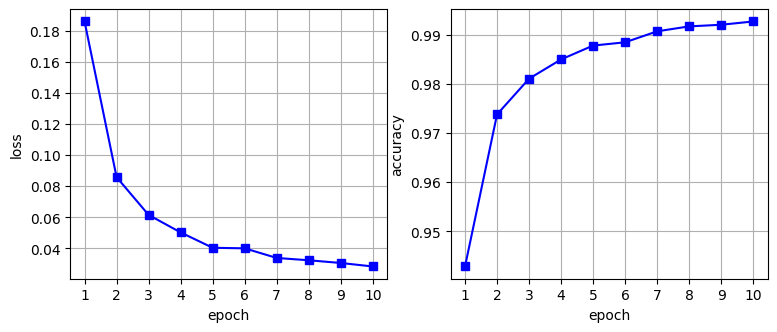

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.set_xticks(xx); ax.plot(xx, H.history['loss'], color='b', marker='s')
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.set_xticks(xx); ax.plot(xx, H.history['accuracy'], color='b', marker='s');

**Evaluación**: del modelo entrenado con train-val y valores óptimos de hiperparámetros

In [15]:
score = M.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

Loss: 0.1682
Precisión: 97.6%
